In [2]:
# Imports
import numpy as np
import math as m
from scipy.integrate import odeint
from scipy.optimize import fminbound
from scipy.optimize import fsolve
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import erfc
from scipy.interpolate import interp1d
from numba.pycc import CC
from numba import jit, njit, vectorize
import pylab


#==============================================================================
# Constants:
#==============================================================================

g = 9.8 # Gravitational const, m/sˆ2
Cp = 1004.0 # Specifc heat of dry air, J/Kg
L = 2.50078e6#2.25e6 # Latent heat of condensation, J/kg
rho_w = 1000.0 # Density of water, kg/mˆ3
rho_a = 1.1839 # Air density, kg/m3, at 1 atm or 101.325 kPa
R = 8.314 # Universal gas constant in J/mol/K
Mw = 18.0 / 1e3 # Molecular weight of water in kg/mol
Ma = 28.9 / 1e3 # Molecular weight of dry air
Rd = R / Ma # Gas constant for dry air in J/kg/K
Rv = R / Mw # Gas constant for water vapor in J/kg/K
ac = 1 # Condensation coefficient, dimensionless
at = 0.96 # Thermal accomodation coefficient, dimensionless
epsilon = Mw/Ma # dimensionless
nsv = 7 # number of state variables

#==============================================================================
# Thermodynamic Functions:
#==============================================================================

def Dv (T, D, P, accom=ac):
    P_atm = P * 1.0123e-5 # Pa -> atm
    Dv_cont = 1e-4 * (0.211 / P_atm) *((T / 273)**1.94)
    denom = 1.0 + (((2*Dv_cont) / (accom * D)) * np.sqrt((2.0 * np.pi * Mw) / (R * T)))
    Dv = Dv_cont/denom
    return Dv

def ka (T, rho, D, accom=at):
    ka_cont = 1e-3 * (4.39 + 0.071 * T)
    denom = 1.0  + (((2.0 * ka_cont) / (accom * D * rho * Cp)) * 
                        np.sqrt((2.0 * np.pi * Ma) / (R * T)))
    ka = ka_cont/denom
    return ka

def es(T):
    Tc = T - 273
    A = [6.107799610e0,
         4.436518521e-1,
         1.428945805e-2,
         2.650648471e-4,
         3.031240396e-6,
         2.034080948e-8,
         6.136820929e-11,
        ]
    vp = A[-1] * Tc
    for ai in reversed(A[1:-1]):
        vp = (vp + ai) * Tc
    vp += A[0]
    es = vp * 100 # mbar -> Pa   
    return es

def sigma_w (T, mode="Pruppacher"):
    if mode=="Pruppacher": 
        Tc = T - 273.15 # K -> ºC
        A = [75.93, # a0
             0.115, # a1
             6.818e-2, # a2
             6.511e-3, # a3
             2.933e-4, # a4
             6.283e-6, # a5
             5.285e-8, # a6
             ]
        sigma_w = A[-1] * Tc
        for ai in reversed(A[1:-1]):
            sigma_w = (sigma_w + ai) * Tc
        sigma_w += A[0]
        sigma_w = sigma_w * 1e-3 # ergs/cm² -> J/m²
        
    elif mode=='Seinfeld':
        sigma_w = 0.0761 - 1.55e-4 * (T - 273)
    return sigma_w

def Tv (T,wv,s):
    wv_sat = wv / (s + 1.0) 
    Tv = (1.0 + 0.61 * wv_sat) * T 
    return Tv

def e (s,T):
    e = (1.0 + s) * es(T)
    return e

def rho_air (P,T,s,wv,dry=True):
    if dry:
        rho_air_dry = (P - e(s,T)) / (Rd * T) 
        rho_air = rho_air_dry
    else: 
        rho_air = P / (Rd * Tv(T,wv,s)) 
    
    return rho_air

def rho_water (T):
    t = T - 273.15 # Temperature in Celsius
    A0 = 999.8396 # unit: kg/mˆ3
    A1 = 18.224944 # unit: kg/(mˆ3 C)
    A2 = -7.92221e-3 # unit: kg/(mˆ3 Cˆ2)
    A3 = -55.44846e-6 # unit: kg/(mˆ3 Cˆ3)
    A4 = 149.7562e-9 # unit: kg/(mˆ3 Cˆ4)
    A5 = -393.2952e-12 # unit: kg/(mˆ3 Cˆ4)
    B = 18.159725e-3 # unit: 1/C
    
    rho_water = (A0 + A1*t + A2*(t**2) + A3*(t**3) + A4*(t**4) + A5*(t**5))/(1+B*t) # kg/mˆ3
    return rho_water

# =============================================================================
# Köhler theory functions: 
# =============================================================================
#Pruppacher
def seq (D, Dd, T, kappa):
    A = (D**3 - Dd**3) / (D**3 - (Dd**3 * (1 - kappa)))
    #usando sigma_w(Seinfeld)
    B = (4.0 * sigma_w(T, mode='Seinfeld') * Mw) / (R * T * rho_water(T) * D)
    seq = A * np.exp(B) -1
    return seq
#Seinfeld
# Supersaturação usando sigma_w def. por Seinfeld (2016)
def ss(D, Dd, T, kappa): 
    A = (D**3 - Dd**3) / (D**3 - (Dd**3 * (1 - kappa)))
    B = (4.0 * sigma_w(T, mode='Seinfeld') * Mw) / (R * T * rho_water(T) * D)
    ss = A * np.exp(B) -1
    return ss
#prup
def sc (T, Dd, kappa, approx=False):
    if approx:
        #Forma aproximada
        A = (4.0 * Mw * sigma_w(T, mode='Seinfeld')) / (R * T * rho_water(T))
        sc_approx = np.exp(np.sqrt((4.0 * (A**3)) / (27 * kappa * (Dd)**3)))
        s_crit = sc_approx - 1
    else:
        neg_seq = lambda D: -1.0 * ss(D, Dd, T, kappa)# Usando sigma_w Seinfeld
        out = fminbound(
            neg_seq, Dd, Dd * 1e4, xtol=1e-10, full_output=True, disp=0
            )
        s_crit = out[1]
        s_crit *= -1.0 # minimum to maximum
    
    return s_crit

#seinfeld
def Dc (T, Dd, kappa, approx=False):   
    if approx:
        A = (4.0 * Mw * sigma_w(T, mode='Seinfeld')) / (R * T * rho_water(T))  
        Dc = np.sqrt((3.0 * kappa * (Dd)**3) / A)
    else:
        neg_seq = lambda D: -1.0 * seq(D, Dd, T, kappa)
        out = fminbound(neg_seq, Dd, Dd * 1e4, xtol=1e-10, full_output=True, disp=0)
        Dc = out[0]
    
    return Dc


# =============================================================================
# Distributions
# =============================================================================

def D_discr (Dmin, Dmax, n_bins):
    D_discr = np.array(np.geomspace(Dmin, Dmax, n_bins +1))    
    return D_discr

def lognormal (D,N,sd,Dmed,mode='pdf'):
    if mode == 'pdf':      
        a = N / (np.sqrt(2.0 * np.pi) * np.log10(sd))
        b = ((np.log10(D / Dmed))**2) / (2.0 * (np.log10(sd))**2)
        lognormal = a * np.exp(-b) * 1e6 # cm^-3 -> m^-3
    elif mode == 'cdf':
        a = (np.log(D / Dmed)) / (np.sqrt(2.0) * np.log(sd))
        lognormal = (N / 2.0) * (1.0 + erf(a)) * 1e6 # cm^-3 -> m^-3
    return lognormal

def Mult_lognormal (D,Ns,sds,Dmeds,mode='pdf'):    
    n = len(Ns)
    Mult_lognormal = 0
    if mode == 'pdf':
        for i in range(n):
            a = Ns[i] / (np.sqrt(2.0 * np.pi) * np.log10(sds[i]))
            b = ((np.log10(D / Dmeds[i]))**2) / (2.0 * (np.log10(sds[i]))**2)
            Mult_lognormal += a * np.exp(-b) * 1e6 # cm^-3 -> m^-3
    elif mode == 'cdf':
        for i in range(n):
            a = (np.log(D / Dmeds[i])) / (np.sqrt(2.0) * np.log(sds[i]))
           # Mult_lognormal += (Ns[i]/2.0) * (1.0 + erf(a))*1e6 # cm^-3 -> m^-3
    return Mult_lognormal

# =============================================================================
# Ode's
# =============================================================================

def dzdt (V):
    dzdt = V
    return dzdt

def dPdt (P,V,T,wv,s):    
    dPdt = (-1.0 * g * P * V ) / (Rd * Tv(T,wv,s))     
    return dPdt

def dTdt (V,dwvdt):
    dTdt = ((-g * V) / Cp) - ((L * dwvdt) / Cp)
    return dTdt

def dwvdt (dwcdt,dwidt):
    dwvdt = -1.0 * (dwcdt + dwidt)
    return dwvdt

def dwcdt (Ni,D,dDdt,P,T,s,wv):  
    dwcdt = dDdt*(Ni * (D)**3) *((np.pi*rho_water(T))/6*(P/Rd*Tv(T,wv,s)))  
    return dwcdt 

def dwidt ():
    dwidt = 0
    return dwidt

def dsdt (T,P,V,dwcdt):
    alpha = (g*Mw*L) / (Cp*R*(T**2)) - (g*Ma)/(R*T)
    gamma = (P*Ma) / (es(T) * Mw) + (Mw*(L**2)) / (Cp*R*(T**2)) 
    dsdt = (alpha*V) - (gamma*dwcdt)
    return dsdt

def dDdt(D,Dd,T,P,s,kappa,accom):
    #rho = rho_air(P, T, s, wv, dry=False)
    D_v = Dv(T, D, P, accom)
    k_a = ka(T, D, rho_a)

    G_a = (rho_water(T) * R * T) / (es(T) * D_v * Mw)
    G_b = (L * rho_water(T) * ((L * Mw / (R * T)) - 1.0)) / (k_a * T)
    G = 1.0 / (G_a + G_b)
    s_eq = seq(D,Dd,T,kappa)
    delta_s = s - s_eq

    dDdt = (G / (D/2)) * delta_s   
    return dDdt

def dYdt (Y, t, nD, Dd_array, N_array, V, kappas_array, accom=ac):
    
    z, P, T, wv, wc, wi, s = Y[:nsv]
    Ds = np.asarray(Y[nsv:])
    
    dz_dt = dzdt(V)
    dP_dt = dPdt (P,V,T,wv,s)
    dDs_dt = np.zeros(nD)
    dwc_dt = 0.0
    for i in range(nD):
        D = Ds[i]
        Dd = Dd_array[i]
        kappa = kappas_array[i] 
        dD_dt = dDdt(D,Dd,T,P,s,kappa,accom)
        Ni = N_array[i]
        dwc_dt += dwcdt (Ni,D,dD_dt,P,T,s,wv)
        dDs_dt[i] = dD_dt
    dwi_dt = dwidt()
    dwv_dt = dwvdt(dwc_dt,dwi_dt)
    dT_dt = dTdt(V,dwv_dt)
    ds_dt = dsdt (T,P,V,dwc_dt)
    
    dYdt = np.zeros(nD + nsv)
    dYdt[:nsv] = dz_dt, dP_dt, dT_dt, dwv_dt, dwc_dt, dwi_dt, ds_dt
    dYdt[nsv :] = dDs_dt[:]
    
    return dYdt 

# =============================================================================
# Droplet activation
# =============================================================================

def log_at(smax, Dmed, sd, Nt, kappa, sgi=None, approx=True):
    if not sgi:
        sgi = sc(T, Dmed, kappa, approx=False)    
    ui = 2.0*np.log10(sgi/ smax) / (3.0 * np.sqrt(2)*np.log10(sd))
    #cumulative CCN spectrum
    N_act = (Nt/2)*erfc(ui) 
    
    return N_act

def NCD(v, N):
    # Distribution of initial dry diameters
    sd, Dmed = 1.35, 60e-9
    N_array = lognormal(Dd_array, N, sd, Dmed)

    y = odeint(dYdt, y0, t, 
            args=(nD, Dd_array, N_array, v, kappas_array, accom,))
    ss = np.max(y[0:,6])
    
    Ncd = log_at(ss, Dmed, sd, N, kappa, sgi=None, approx=True)
    
    return Ncd
    


In [3]:
with open("output_reutter1.csv", "w") as out_file:
    for i in range(len(b)):
        out_str = ""
        out_str += str(N[i])
        out_str += ";" + str(v[i])
        out_str += ";" + str(b[i])
        out_str += "\n"
        out_file.write(out_str)

NameError: name 'b' is not defined

In [5]:
# =============================================================================
# Plot Fig 3 Reutter
# =============================================================================

Dg = 60e-9
sd = 1.35
Dmin, Dmax = 2e-8, Dg*(sd**4) 
nD = 95 # Número de bins
Dd_array = D_discr(Dmin, Dmax, nD - 1)
kappa = 1.28 #NaCl
# Definition of initial state
y0 = np.zeros(nD + nsv)
z0, P0, T0, wv0, wc0, wi0, s0 = 671.5, 950e2, 285.2, 0.0, 0.0, 0.0, 0.0
y0[:nsv] = z0, P0, T0, wv0, wc0, wi0, s0
# Finding critical diameters
D_crit = np.zeros(len(Dd_array))
for i in range(len(Dd_array)):    
    D_crit[i] = Dc(T0, Dd_array[i], kappa)   
 
y0[nsv:] = D_crit
# Time discretization
t = np.array(np.linspace(0, 1500.0, 500000))

accom = 1
kappas_array = np.zeros(nD)
for i in range (nD):
    kappas_array[i] = kappa

In [6]:
h = 5
T = T0
v = np.linspace(0.5,3.5, num=h)
N = np.linspace(800,3600, num=h)

b = np.zeros((h,h))
for i in range(h):
    for j in range(h):
        b[i,j] = NCD(v[i],N[j])



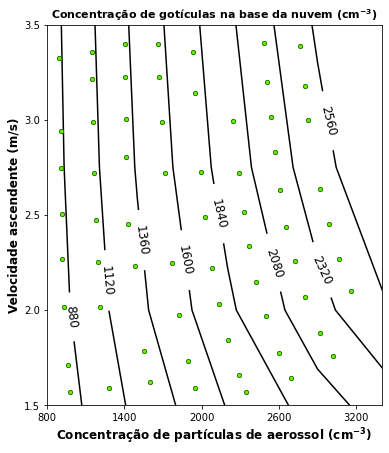

In [10]:
fig=plt.figure()
fig.set_size_inches(6,7)
plt.title(r'Concentração de gotículas na base da nuvem $\bf{(cm^{-3})}$',fontsize=11, fontweight="bold")
plt.xlabel(r'Concentração de partículas de aerossol $\bf{(cm^{-3})}$',fontsize=12, fontweight="bold")
plt.ylabel('Velocidade ascendente (m/s)',fontsize=12, fontweight="bold")
levels = [880, 1120, 1360, 1600, 1840, 2080, 2320, 2560]
contours = plt.contour(N, v, b, levels, colors='black')
manual_locations = [(900,1.95),(1200,2.15),(1400,2.35),(1800,2.25),(2100,2.5),(2400,2.20),(2800,2.15), (3000,3.0)]
plt.clabel(contours, inline=1, fontsize=12,manual=manual_locations)
plt.xticks((800,1400,2000,2600,3200))
plt.yticks((1.5,2.0,2.5,3.0,3.5))
plt.ylim(1.5,3.5)
plt.xlim(800,3400)
data = np.genfromtxt("alex_reutter_2.txt", delimiter=";", names=["N", "v"])
plt.plot(data['N'], data['v'], '8', ms = 5, mec = '#337d05', mfc = '#60f702', label='$Reutter, 2009$')

#plt.savefig("0_003s_", dpi=600, facecolor='w')
plt.show()